<a href="https://colab.research.google.com/github/AymanAl-Rashidi/openCV-object-detection-demo/blob/main/opencv_object_detection_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenCV Basics Notebook  
_Image Processing, Object Detection & Face Detection_

In [52]:
# If needed, install packages (uncomment and run once)
# !pip install opencv-python opencv-contrib-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.12.0


## Helper function for displaying images

Matplotlib expects images in **RGB** order, while OpenCV uses **BGR**.  
We will use a small helper to show images correctly in this notebook.

In [53]:
def show_img(img, title="Image", cmap=None, size=6):
    """Display an image using matplotlib."""
    plt.figure(figsize=(size, size))
    if len(img.shape) == 2 or cmap is not None:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        # Convert BGR (OpenCV) to RGB (matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Load a sample image

> 👉 Replace `'sample.jpg'` with the path to your own image file.

Image shape (H, W, C): (3072, 4096, 3)


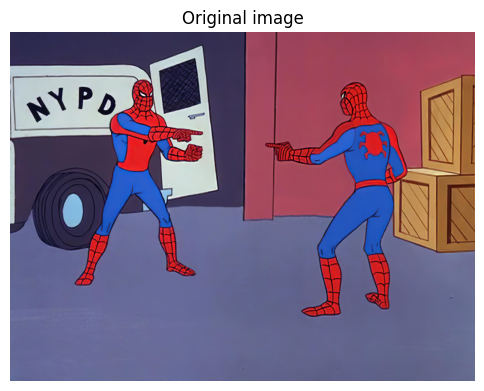

In [54]:
IMAGE_PATH = '/content/Spider.jpg'  # TODO: change this to your image path

img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}. Please check the path.")

print("Image shape (H, W, C):", img.shape)
show_img(img, title="Original image")

---
## 1. Reading Images

OpenCV reads images using `cv2.imread(path)`.  
The result is a NumPy array of shape `(height, width, channels)` in **BGR** color order.

Color: (3072, 4096, 3)
Gray: (3072, 4096)
Unchanged shape: (3072, 4096, 3)


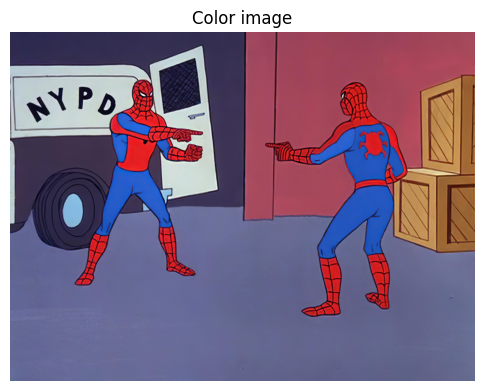

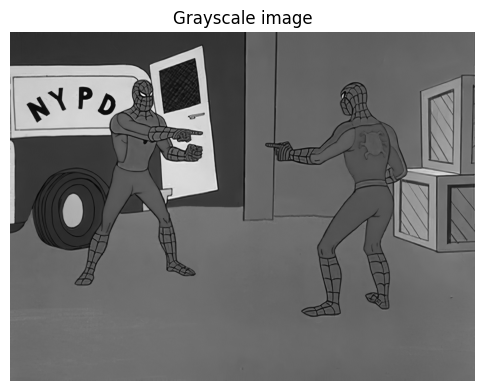

In [55]:
# Read image in different modes
img_color = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)      # default
img_gray  = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)  # 1 channel
img_unchanged = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)  # keep alpha if exists

print("Color:", img_color.shape)
print("Gray:", img_gray.shape)
print("Unchanged shape:", img_unchanged.shape)

show_img(img_color, title="Color image")
show_img(img_gray, title="Grayscale image", cmap='gray')

---
## 2. Color Conversions

Common conversions:

- BGR → Grayscale  (`cv2.COLOR_BGR2GRAY`)
- BGR → RGB       (`cv2.COLOR_BGR2RGB`)
- BGR → HSV       (`cv2.COLOR_BGR2HSV`)

HSV is especially useful for **color-based segmentation**.

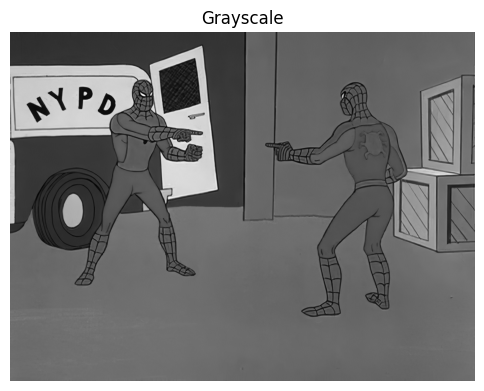

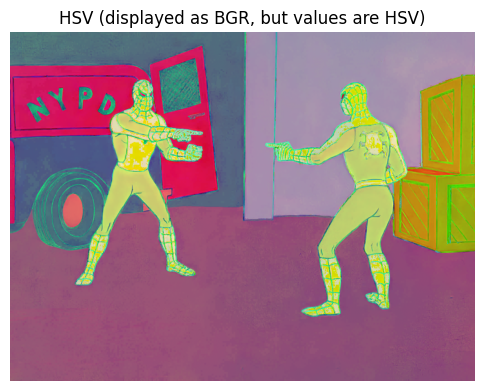

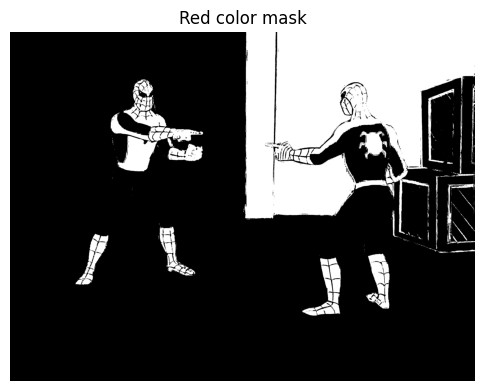

In [56]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

show_img(gray, title="Grayscale", cmap='gray')
show_img(hsv, title="HSV (displayed as BGR, but values are HSV)")

# Example: simple color mask (e.g. detect strong reds)
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = mask1 | mask2

show_img(red_mask, title="Red color mask", cmap='gray')

---
## 3. Resizing & Cropping

- **Resize**: `cv2.resize(img, (width, height))`  
- **Crop**: NumPy slicing: `crop = img[y1:y2, x1:x2]`

Original size: 4096 x 3072


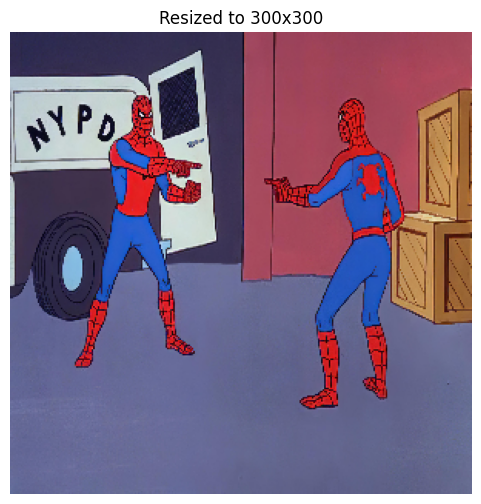

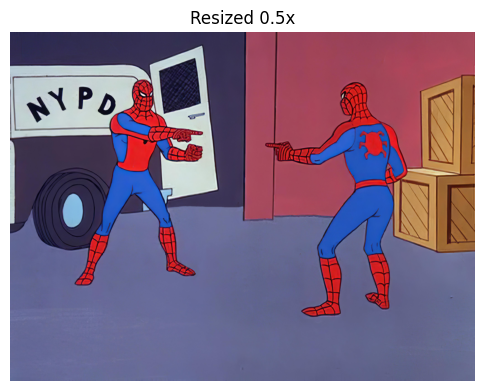

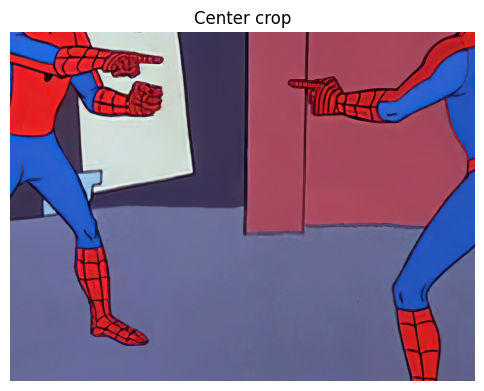

In [57]:
h, w = img.shape[:2]
print("Original size:", w, "x", h)

# Resize to fixed size
resized_fixed = cv2.resize(img, (300, 300))
show_img(resized_fixed, title="Resized to 300x300")

# Resize with aspect ratio (scale by 0.5)
resized_half = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
show_img(resized_half, title="Resized 0.5x")

# Simple center crop (take middle region)
crop = img[h//4: 3*h//4, w//4: 3*w//4]
show_img(crop, title="Center crop")

---
## 4. Filters (Blur, Edge, Sharpen)

### 4.1 Blurring

- `cv2.GaussianBlur` – smooths noise, keeps edges relatively sharp  
- `cv2.medianBlur`  – good for salt & pepper noise  
- `cv2.blur`        – simple average filter

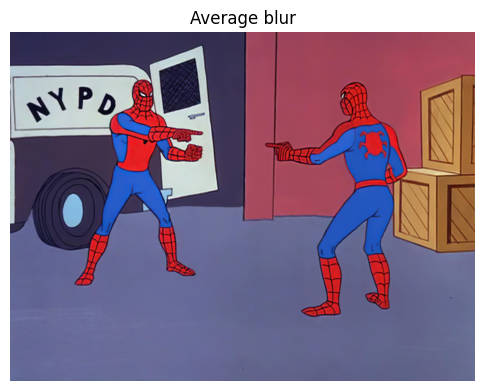

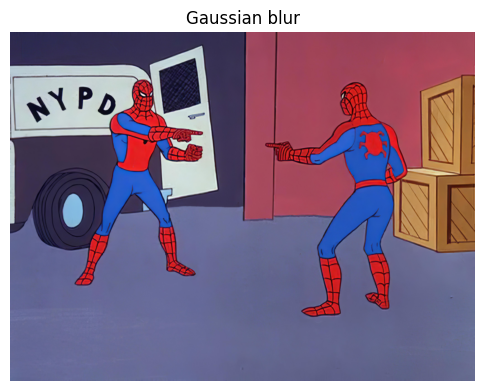

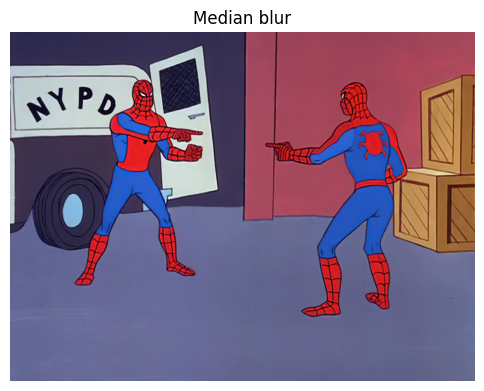

In [58]:
kernel_size = (7, 7)

blur_avg = cv2.blur(img, kernel_size)
blur_gauss = cv2.GaussianBlur(img, kernel_size, sigmaX=0)
blur_median = cv2.medianBlur(img, 7)

show_img(blur_avg,   title="Average blur")
show_img(blur_gauss, title="Gaussian blur")
show_img(blur_median, title="Median blur")

### 4.2 Edge Detection (Canny)

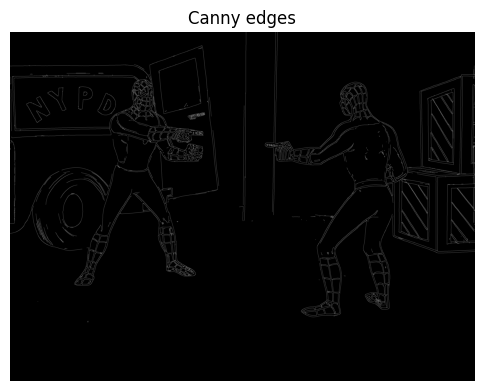

In [59]:
edges = cv2.Canny(gray, threshold1=100, threshold2=200)
show_img(edges, title="Canny edges", cmap='gray')

### 4.3 Sharpening

We can sharpen an image using a **convolution kernel**.

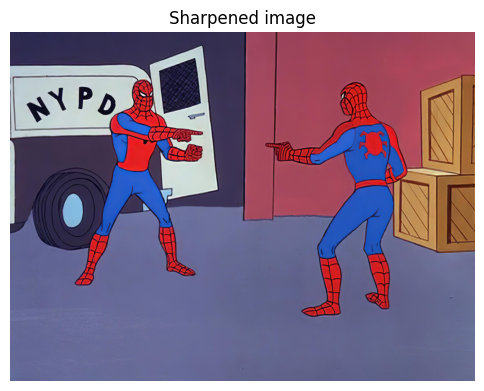

In [60]:
# Sharpening kernel
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], np.float32)
sharpened = cv2.filter2D(img, -1, kernel_sharpen)
show_img(sharpened, title="Sharpened image")

---
## 5. Thresholding

Thresholding converts a grayscale image to **binary** (black/white).  
Useful for segmentation and preparing images for contour detection.

Types we will see:

- Simple global threshold  
- Otsu's threshold (automatic)  
- Adaptive threshold

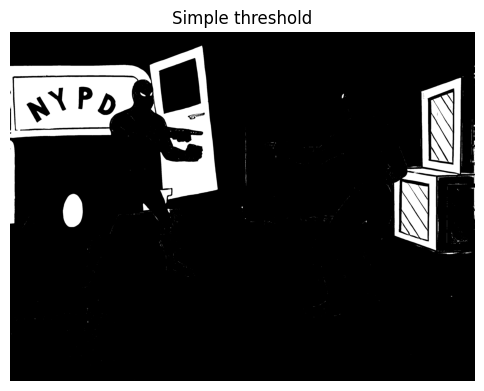

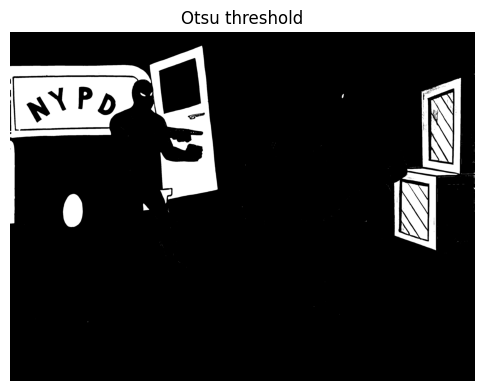

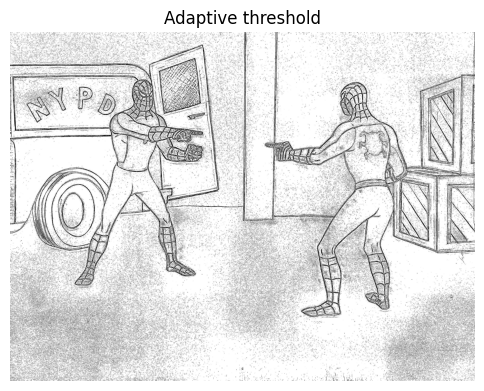

In [61]:
# Simple global threshold
ret, th_simple = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Otsu's threshold (chooses threshold automatically)
ret2, th_otsu = cv2.threshold(
    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Adaptive threshold (works with varying illumination)
th_adapt = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    blockSize=11,
    C=2
)

show_img(th_simple, title="Simple threshold", cmap='gray')
show_img(th_otsu, title="Otsu threshold", cmap='gray')
show_img(th_adapt, title="Adaptive threshold", cmap='gray')

---
## 7. Contours

Contours are curves joining all continuous points along a boundary.  
We often find them on **binary images** to locate objects.

Steps:

1. Threshold or edge detection  
2. `cv2.findContours`  
3. Draw contours or bounding boxes

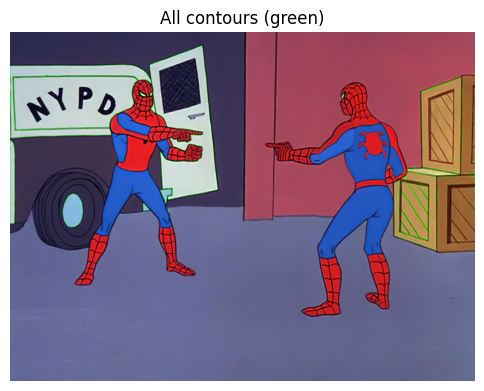

Number of contours: 343


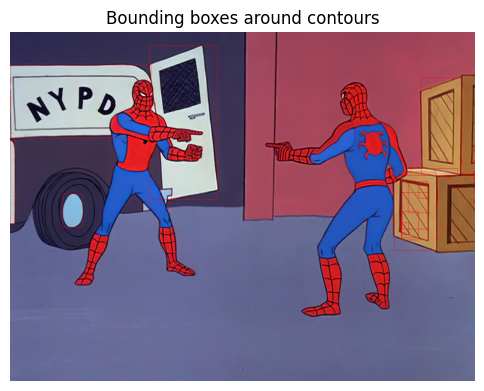

In [62]:
# Use Otsu's threshold as base
contours, hierarchy = cv2.findContours(
    th_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
show_img(img_contours, title="All contours (green)")

print("Number of contours:", len(contours))

# Draw bounding boxes
img_boxes = img.copy()
for cnt in contours:
    x, y, w_box, h_box = cv2.boundingRect(cnt)
    cv2.rectangle(img_boxes, (x, y), (x + w_box, y + h_box), (0, 0, 255), 2)

show_img(img_boxes, title="Bounding boxes around contours")

---
## 8. Drawing & Annotation

OpenCV can draw simple shapes and text on images:

- `cv2.line`  
- `cv2.rectangle`  
- `cv2.circle`  
- `cv2.putText`

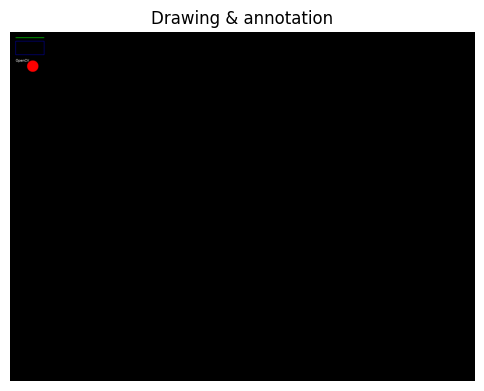

In [63]:
canvas = np.zeros_like(img)  # black canvas same size as image

# Draw a line
cv2.line(canvas, (50, 50), (300, 50), (0, 255, 0), 3)

# Draw a rectangle
cv2.rectangle(canvas, (50, 80), (300, 200), (255, 0, 0), 2)

# Draw a filled circle
cv2.circle(canvas, (200, 300), 50, (0, 0, 255), thickness=-1)

# Put text
cv2.putText(canvas, 'OpenCV', (50, 260),
            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

show_img(canvas, title="Drawing & annotation")

9. Webcam / Video Capture (optional)
The following code opens your webcam and shows the live video.

⚠️ This usually does not work inside Jupyter/Colab.
Run it as a normal Python script on your computer.

In [64]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Webcam is OFF or not available.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        cv2.imshow('Webcam', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


Webcam is OFF or not available.


---
## 10. Face Detection *(optional)*

We use a pretrained **Haar Cascade** provided by OpenCV.

Steps:

1. Load cascade  
2. Convert image to grayscale  
3. Run `detectMultiScale`  
4. Draw rectangles around detected faces

Detected 3 face(s)


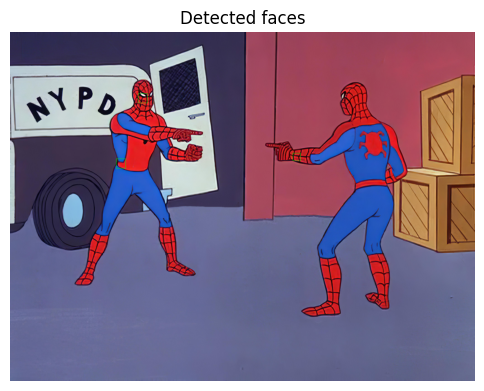

In [65]:
# Load Haar cascade (comes with opencv-python)
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(
    gray_img,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)

print(f"Detected {len(faces)} face(s)")

img_faces = img.copy()
for (x, y, w_box, h_box) in faces:
    cv2.rectangle(img_faces, (x, y), (x + w_box, y + h_box), (0, 255, 0), 2)

show_img(img_faces, title="Detected faces")

---
## 11. Using OpenCV with a CNN *(optional, simple demo)*

Here we show a **very simple example** of using a pretrained CNN  
(from `torchvision`) to classify the image, and we still use OpenCV for loading.

> This section requires `torch` and `torchvision` to be installed.  
> You can skip it if those libraries are not available.

Predicted: comic book (confidence 0.76)


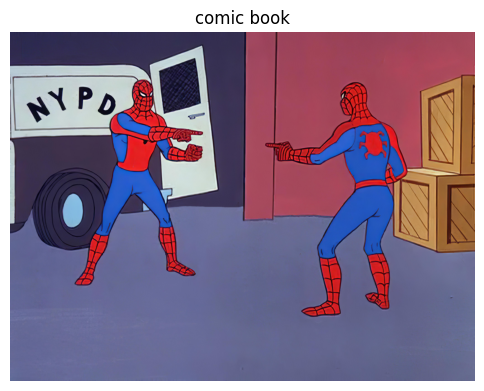

In [66]:

import torch
import torchvision.transforms as T
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

# Preprocessing for ResNet18
preprocess = models.ResNet18_Weights.DEFAULT.transforms()

# Convert BGR (OpenCV) to RGB, then to PIL
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
import PIL.Image as Image
pil_img = Image.fromarray(img_rgb)

input_tensor = preprocess(pil_img).unsqueeze(0)  # add batch dim

with torch.no_grad():
    output = model(input_tensor)
    probs = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_idx = probs.topk(1)

# Load class names
categories = models.ResNet18_Weights.DEFAULT.meta['categories']
predicted_label = categories[top_idx.item()]
print(f"Predicted: {predicted_label} (confidence {top_prob.item():.2f})")
show_img(img, title=predicted_label)

---
## Exercises for Students

1. **Change image** – use a different image and re-run all cells.  
2. **Color mask** – detect a *different* color (e.g. blue or green) using HSV.  
3. **Shape detector** – use contours to detect and draw boxes only around large objects.  
4. **Noise removal** – experiment with different blurs + morphology to clean a noisy binary image.  
5. **Mini project** – combine webcam capture + face detection to build a simple "face camera" app.

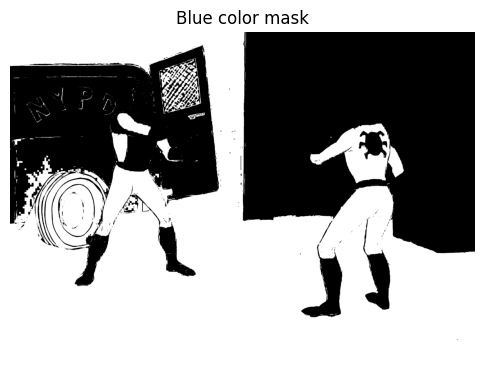

In [67]:
# Blue mask Exercises 2

lower_blue = np.array([90, 50, 50])
upper_blue = np.array([130, 255, 255])

blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
show_img(blue_mask, title="Blue color mask", cmap='gray')


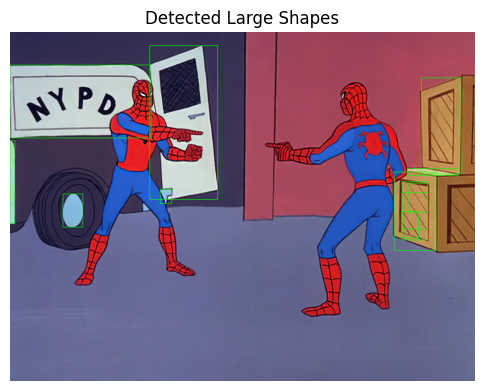

In [68]:
# Shape detector - Exercise 3

# 1) Convert to grayscale
gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2) Apply threshold (binary image)
ret, thresh = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3) Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_shapes = img.copy()

# 4) Filter only LARGE objects
min_area = 5000
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_shapes, (x, y), (x + w, y + h), (0, 255, 0), 3)

# 5) Show result
show_img(img_shapes, title="Detected Large Shapes")


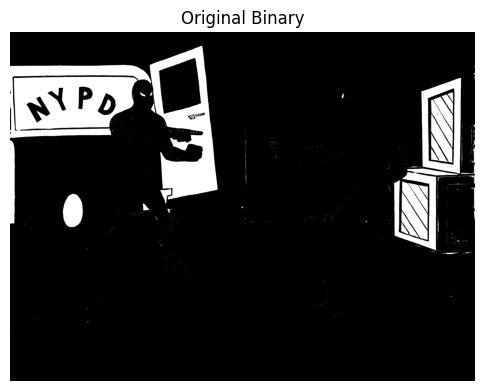

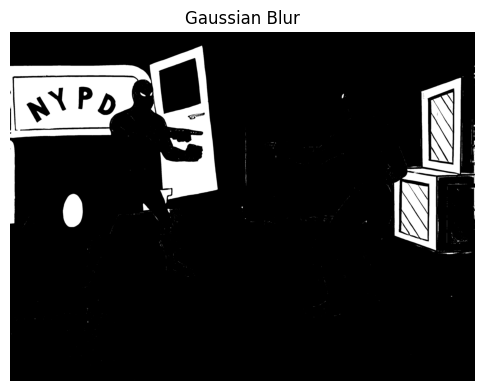

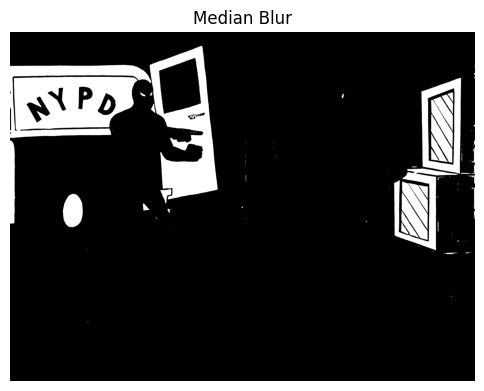

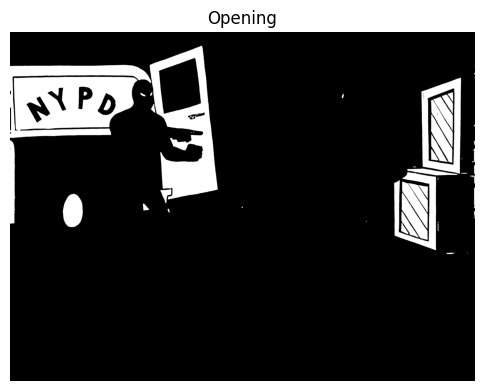

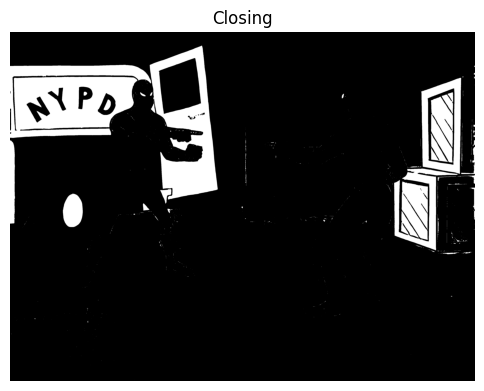

In [69]:
#Noise removal Exercises 3
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

show_img(th, title="Original Binary", cmap='gray')

gauss = cv2.GaussianBlur(th, (5,5), 0)
median = cv2.medianBlur(th, 5)

show_img(gauss, title="Gaussian Blur", cmap='gray')
show_img(median, title="Median Blur", cmap='gray')

kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

show_img(opening, title="Opening", cmap='gray')
show_img(closing, title="Closing", cmap='gray')


In [70]:
#Ex 5

import cv2

def run_face_camera_app():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("Face detection app started. Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to grab frame.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, "Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

        cv2.imshow("Face Camera App", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    run_face_camera_app()



Error: Could not open webcam.
